In [1]:
!pip install -q pygraphviz

In [2]:
!pip install -q wfcommons

In [3]:
!pip install -q parse

In [4]:
from wfcommons.wfchef.recipes import *
from wfcommons.wfchef.utils import *
from wfcommons import WorkflowGenerator
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
import matplotlib.pyplot as plt
import requests
from pprint import pprint

from typing import List

# The first option is to generate a synthetic workflow based on some predefined patterns
e.g., BlastRecipe, BwaRecipe, CyclesRecipe, EpigenomicsRecipe, GenomeRecipe, MontageRecipe, SeismologyRecipe, SoykbRecipe, SrasearchRecipe. See [here](https://wfcommons.org/generator) and [here](https://github.com/wfcommons/wfcommons/tree/438983117dc9ccf8b642339d81edef2ae992e34d/wfcommons/wfgen).

-- issue: the machines field won't be filled (it provides only jobs)





In [22]:
# TASKS_NUM = 25
# generator = WorkflowGenerator(SrasearchRecipe.from_num_tasks(TASKS_NUM))
# workflow = generator.build_workflow()
# DAG_synthetic = workflow.to_nx_digraph()
# workflow.write_json('srasearch-workflow.json')

In [23]:
def display_graph(graph):
  pos = graphviz_layout(graph, prog='dot')
  plt.figure(figsize=(14,10)) 
  nx.draw(graph, pos=pos, node_size=2000, with_labels=True, arrows=True)

In [24]:
# display_graph(DAG_synthetic)

# The second option is to read a workflow from a file
There are a few available workflow instances on Github: [pegasus-instances](https://github.com/wfcommons/pegasus-instances) and [makeflow-instances](https://github.com/wfcommons/makeflow-instances). There're json files where jobs are already assigned to machines.

In [88]:
url = 'https://raw.githubusercontent.com/wfcommons/pegasus-instances/master/srasearch/chameleon-cloud/srasearch-chameleon-10a-001.json'
url = 'https://raw.githubusercontent.com/wfcommons/pegasus-instances/master/1000genome/chameleon-cloud/1000genome-chameleon-14ch-100k-001.json'
resp = requests.get(url)
data = json.loads(resp.text)
print(data)
path = 'pegasus-workflow.json'
# workflow.write_json(path)
with open(path, 'w') as f:
    json.dump(data, f)



{'name': '1000genome-20200401T153108Z-0', 'description': 'Trace generated with wrench-pegasus-parser.py from http://wrench-project.org', 'createdAt': '2020-04-01T20:23:49.256573Z', 'schemaVersion': '1.2', 'wms': {'url': 'http://pegasus.isi.edu', 'version': '4.9.3', 'name': 'Pegasus'}, 'author': {'name': 'rafsilva', 'email': 'support@wrench-project.org'}, 'workflow': {'makespan': 2290.0, 'jobs': [{'name': 'individuals_ID0000001', 'type': 'compute', 'runtime': 61.593, 'parents': [], 'files': [{'link': 'input', 'name': 'columns.txt', 'size': 20078}, {'link': 'input', 'name': 'ALL.chr1.100000.vcf', 'size': 1014258222}, {'link': 'output', 'name': 'chr1n-1-1001.tar.gz', 'size': 27959}], 'avgCPU': 143.3507, 'machine': 'pegasus-2', 'priority': 20, 'id': 'ID0000001', 'category': 'individuals', 'command': {'program': 'individuals', 'arguments': ['ALL.chr1.100000.vcf', '1', '1', '1001', '10000']}}, {'name': 'individuals_ID0000002', 'type': 'compute', 'runtime': 65.301, 'parents': [], 'files': [{'

In [89]:
DAG_real = create_graph(path)
# annotate(DAG) # I thought that this line migth append some data to the DAG, but that's not the case https://github.com/wfcommons/wfcommons/blob/4abe2545998a7b29e65e94f95d7c32d7c9afdc78/wfcommons/wfchef/utils.py

In [90]:
nodes = DAG_real.nodes()

In [91]:
edges = DAG_real.edges()

In [92]:
in_degrees = DAG_real.in_degree(nodes)
out_degrees = DAG_real.out_degree(nodes)

In [93]:
nodes_connected_to_source = [node for (node, in_degree) in in_degrees if in_degree == 0]
nodes_connected_to_sink = [node for (node, out_degree) in out_degrees if out_degree == 0]

In [94]:
print('nodes_connected_to_source', nodes_connected_to_source)
print('nodes_connected_to_sink', nodes_connected_to_sink)

nodes_connected_to_source ['SRC']
nodes_connected_to_sink ['DST']


In [95]:
paths = list(nx.all_simple_paths(DAG_real, source='SRC', target='DST'))

In [96]:
paths_amount = len(paths)
print(f'Amount of paths: {paths_amount}')

Amount of paths: 2156


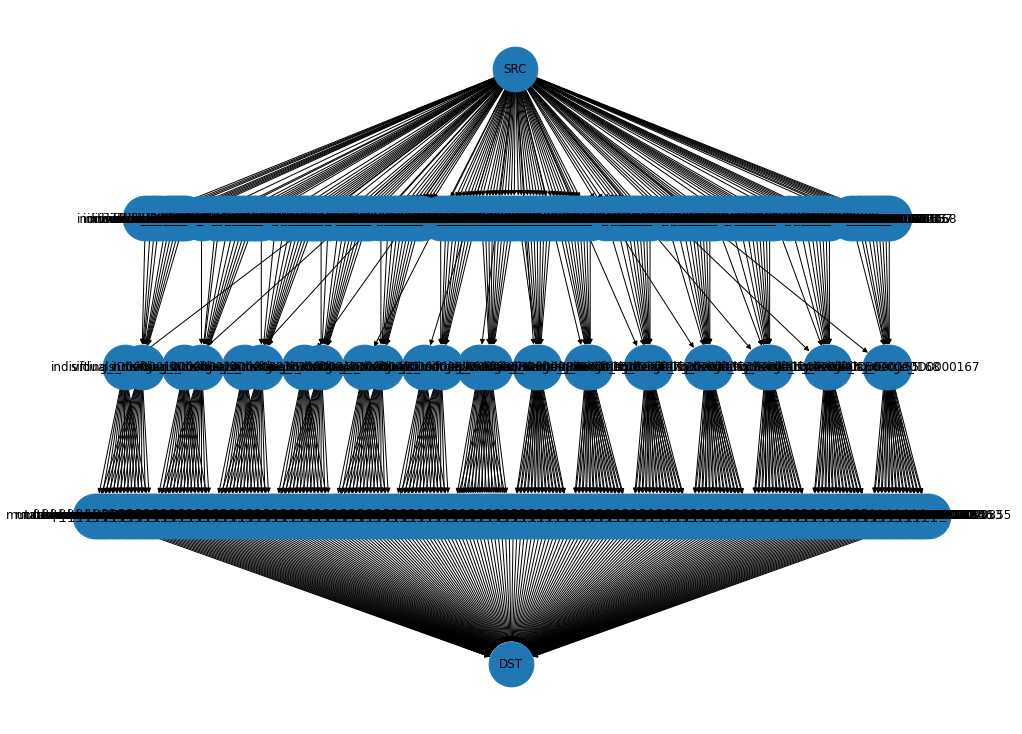

In [97]:
display_graph(DAG_real)

So lets get some data :)

In [35]:
class Machine(object):
  def __init__(self, machine):
    self.name = machine.get('nodeName')
    self.system = machine.get('system')
    self.architecture = machine.get('architecture')
    self.release = machine.get('release')
    self.cpu = machine.get('cpu')
    self.memory = machine.get('memory')
  def __repr__(self):
    return str(vars(self))

  def __str__(self):
    return str(vars(self))


class Job(object):
  def __init__(self, id, name, children, parents, machine, inputs, outputs, runtime, used_memeory, normalized_runtime):
    self.id = id
    self.name = name
    self.children = children
    self.parents = parents
    self.machine = machine
    self.inputs = inputs
    self.outputs = outputs
    self.runtime = runtime
    self.used_memeory = used_memeory
    self.normalized_runtime = normalized_runtime


  def find_and_set_parents(self, jobs):
    parent_jobs = []
    for j in jobs:
      for p in self.parents:
        if p == j.name:
          parent_jobs.append(j)
    self.parents = parent_jobs

  def find_and_set_children(self, jobs):
    children_jobs = []
    for j in jobs:
      for c in self.children:
        if c == j.name:
          children_jobs.append(j)
    self.children = children_jobs


  def __repr__(self):
    return str(f"['{self.name}']: on machine '{self.machine.name}' parent: '{[p.name for p in self.parents]}' children: '{[c.name for c in self.children]}'" )

  # def __str__(self):
  #   return str(vars(self))

class JobBuilder(object):
  def __init__(self, job, *, machine_name = None):
    self.id = job.get('id')
    self.name = job.get('name')
    self.category =  job.get('category') 
    self.children_names = job.get('children') or [] 
    self.parent_names = job.get('parents') or [] 
    self.commmand = job['command'].get('program') 
    self.arguments = job['command'].get('arguments')
    files = job.get('files')
    if files is None:
      self.inputs = []
      self.outputs = []
    else: 
      self.inputs = [ (file.get('name'), file.get('size')) for file in files if file.get('link') == 'input']
      self.outputs = [ (file.get('name'), file.get('size')) for file in files if file.get('link') == 'output']
      
    self.avg_cpu_usage = job.get('avgCPU')
    self.used_memeory = job.get('memory')
    self.priotrity = job.get( 'priority')
    self.runtime = job.get('runtime')
    self.type = job.get('type')
    self.normalized_runtime = 1

  def __repr__(self):
    return str(vars(self))

  def __str__(self):
    return str(vars(self))

  def set_machine(self, machine : Machine):
    self.machine = machine

  def build(self) -> Job:
    return Job(id = self.id, name = self.name, children = self.children_names, parents = self.parent_names, machine = self.machine, inputs = self.inputs, outputs = self.outputs, runtime = self.runtime, used_memeory = self.used_memeory, normalized_runtime = self.normalized_runtime)

In [36]:
json_data = data

In [37]:
#@title Domyślny tekst tytułu
machines =  [Machine(machine) for machine in json_data['workflow']['machines']]
machines = { machine.name : machine for machine in machines}

jobs_b = [ (JobBuilder(job), job['machine']) for job in json_data['workflow']['jobs']]

pprint(machines)
for job, machine_name in jobs_b:
    job.set_machine(machines[machine_name])
    job.normalized_runtime = job.runtime / job.machine.cpu['speed'] * job.machine.cpu['count']

min_runtime = min(map(lambda x: x[0].normalized_runtime, jobs_b))

for j,_ in jobs_b:
  j.normalized_runtime /= min_runtime

jobs = [job.build() for job, _ in jobs_b]



for j in jobs:
  j.find_and_set_parents(jobs)
  j.find_and_set_children(jobs)


{'worker-4': {'name': 'worker-4', 'system': 'linux', 'architecture': 'x86_64', 'release': '4.15.0-121-generic', 'cpu': {'count': 48, 'speed': 1274, 'vendor': 'GenuineIntel'}, 'memory': 131795960}}


In [38]:
print(f'Jobs: {len(jobs)}')
print(f'Machines: {len(machines)}')

Jobs: 22
Machines: 1


# Cyfronet Machines

Lets define some machines that are available for AGH.

In [39]:
base_cpu_hour_price = 0.08
base_gpu_hour_price = 5.0
gpu_speed_vs_cpu = 100

cpus = {'Zeus': 0.25, 'Prometeus': 1 , 'Ares': 1.6}
cpus_base_memory = {'Zeus': 2, 'Prometeus': 4 , 'Ares': 8}
cpus_more_memory_factor = {'Zeus': 0.2, 'Prometeus': 0.40 , 'Ares': 0.80}


gpus = {'Prometeus': 1 , 'Ares': 1.6}
gpus_base_memory = {'Prometeus': 4 , 'Ares': 8}
gpus_more_memory_factor = {'Prometeus': 0.40 , 'Ares': 0.80}


cyfronet_machines = {}
for cpu in cpus.keys():
  cyfronet_machines[f"{cpu}Cpu"] = {
      'base_price' :  base_cpu_hour_price,
      'base_memory' : cpus_base_memory[cpu],
      'memory_cost_multiplayer' : cpus_more_memory_factor[cpu],
      'speed': cpus[cpu]
  }
for gpu in gpus.keys():
  cyfronet_machines[f"{gpu}Gpu"] = {
      'base_price' : base_gpu_hour_price,
      'base_memory' : gpus_base_memory[gpu],
      'memory_cost_multiplayer' : gpus_more_memory_factor[gpu],
      'speed' : gpus[gpu] * gpu_speed_vs_cpu
  }



In [40]:
import math
def calc_cost(machine , job):
  if job.used_memeory is not None:
    mib_free = 1024 * machine['base_memory']
    cost_power = (job.used_memeory - mib_free) // 1024
  else:
    cost_power = 0
  runtime = job.normalized_runtime
  return runtime * machine['base_price'] * (1 + machine['memory_cost_multiplayer']* cost_power) / machine['speed']

In [41]:
costs = {}
runtimes = {}
for machine in cyfronet_machines:
  machine_cost = []
  machine_runtime = []
  for j in jobs:
    machine_cost.append(calc_cost(cyfronet_machines[machine], j))
    machine_runtime.append( j.normalized_runtime / cyfronet_machines[machine]['speed'])
  costs[machine] = machine_cost
  runtimes[f"{machine}Runtime"] = machine_runtime

In [42]:
import pandas as pd
import numpy as np

In [43]:
cost_df = pd.DataFrame(data=costs, index = [j.name for j in jobs])
cost_df

,ZeusCpu,PrometeusCpu,AresCpu,PrometeusGpu,AresGpu
bowtie2-build_ID0000001,335.827478,159.959930,188.350609,99.974957,117.719130
fasterq-dump_ID0000002,159221.188452,78487.560765,96471.693826,49054.725478,60294.808641
bowtie2_ID0000003,873.724104,369.073113,362.482522,230.670696,226.551576
fasterq-dump_ID0000004,46585.664000,22726.249600,27581.546000,14203.906000,17238.466250
bowtie2_ID0000005,782.037704,330.343513,324.444522,206.464696,202.777826
fasterq-dump_ID0000006,87037.907478,42741.829565,52293.980870,26713.643478,32683.738043
bowtie2_ID0000007,860.093217,358.372174,343.440000,223.982609,214.650000
fasterq-dump_ID0000008,39946.646817,19447.709635,23543.116957,12154.818522,14714.448098
bowtie2_ID0000009,673.529322,280.637217,268.944000,175.398261,168.090000
fasterq-dump_ID0000010,114676.087096,56526.656139,69475.046870,35329.160087,43421.904293


In [44]:
runtime_df = pd.DataFrame(data=runtimes, index = [j.name for j in jobs])
runtime_df

,ZeusCpuRuntime,PrometeusCpuRuntime,AresCpuRuntime,PrometeusGpuRuntime,AresGpuRuntime
bowtie2-build_ID0000001,220.939130,55.234783,34.521739,0.552348,0.345217
fasterq-dump_ID0000002,31195.373913,7798.843478,4874.277174,77.988435,48.742772
bowtie2_ID0000003,1883.026087,470.756522,294.222826,4.707565,2.942228
fasterq-dump_ID0000004,15738.400000,3934.600000,2459.125000,39.346000,24.591250
bowtie2_ID0000005,1685.426087,421.356522,263.347826,4.213565,2.633478
fasterq-dump_ID0000006,21586.782609,5396.695652,3372.934783,53.966957,33.729348
bowtie2_ID0000007,1990.956522,497.739130,311.086957,4.977391,3.110870
fasterq-dump_ID0000008,14600.382609,3650.095652,2281.309783,36.500957,22.813098
bowtie2_ID0000009,1559.095652,389.773913,243.608696,3.897739,2.436087
fasterq-dump_ID0000010,22538.539130,5634.634783,3521.646739,56.346348,35.216467


In [45]:

# flat_runtimes = [runtime for n, machine_runtimes in runtimes.items() for runtime in machine_runtimes]
flat_runtimes = [(runtime, name) for n, machine_runtimes in runtimes.items() for runtime, name in zip(machine_runtimes, [j.name for j in jobs])]

R = np.zeros(shape=(len(flat_runtimes),len(paths)), dtype=np.float32)

for i, (job, name) in enumerate(flat_runtimes):
    for j, path in enumerate(paths):
      for node in path:
        if name == node:
          R[i,j] = job

pprint(f'Shape {R.shape}')
pprint(R)


'Shape (110, 20)'
array([[2.2093913e+02, 2.2093913e+02, 2.2093913e+02, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [1.8830261e+03, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 5.0067390e+01],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 4.5925546e+00],
       [6.2500001e-03, 6.2500001e-03, 6.2500001e-03, ..., 6.2500001e-03,
        6.2500001e-03, 6.2500001e-03]], dtype=float32)


In [46]:
y_size =  np.array(cost_df).shape[0] * np.array(cost_df).shape[1]
USE_ONE_MACHINE  = np.zeros(shape=( y_size, np.array(cost_df).shape[0]), dtype = np.float32)
for i in range(len(jobs)):
  for j in range(i, y_size, len(jobs)):
    USE_ONE_MACHINE[j,i] = 1

USE_ONE_MACHINE

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [47]:
DEADLINE = 40000

In [48]:
PATHS =  (R).astype(np.int32)
PATHS

array([[ 220,  220,  220, ...,    0,    0,    0],
       [   0,    0,    0, ...,    0,    0,    0],
       [1883,    0,    0, ...,    0,    0,    0],
       ...,
       [   0,    0,    0, ...,    0,    0,   50],
       [   0,    0,    0, ...,    0,    0,    4],
       [   0,    0,    0, ...,    0,    0,    0]])

In [49]:
POWERS_2 = [ 2 ** i for i in range(np.ceil(np.log2(DEADLINE)).astype(np.int32))]
POWERS_2

SLACK = np.zeros(shape=(PATHS.shape[0], PATHS.shape[0] * len(POWERS_2))).astype(np.int32)

for i in range(0, SLACK.shape[0]):
    SLACK[i, i * len(POWERS_2):(i + 1) * len(POWERS_2)] = POWERS_2
SLACK

array([[    1,     2,     4, ...,     0,     0,     0],
       [    0,     0,     0, ...,     0,     0,     0],
       [    0,     0,     0, ...,     0,     0,     0],
       ...,
       [    0,     0,     0, ...,     0,     0,     0],
       [    0,     0,     0, ...,     0,     0,     0],
       [    0,     0,     0, ...,  8192, 16384, 32768]])

In [50]:
A = np.concatenate((PATHS,SLACK), axis=1)


U = np.concatenate((USE_ONE_MACHINE, np.zeros(shape = (USE_ONE_MACHINE.shape[0], SLACK.shape[1]))), axis = 1)
if U.shape[1] - A.shape[1] > 0:
  A = np.pad(A, [(0, 0), (0, U.shape[1] - A.shape[1])], mode='constant', constant_values=0)
elif U.shape[1] - A.shape[1] < 0:
  U = np.pad(U, [(0, 0), (0, A.shape[1] - U.shape[1])], mode='constant', constant_values=0)

b_paths = np.array([DEADLINE for i in range(A.shape[0])] , dtype=np.int32 )
b_machines = np.array([1 for i in range(U.shape[0]) ] , dtype=np.int32 )
b = np.concatenate((b_paths, b_machines), axis = 0)
  
A = np.pad(A, [(0, 0), (0, U.shape[1] - A.shape[1])], mode='constant', constant_values=0)
S = 10000

print(f'PATHS shape {PATHS.shape}')
print(f'SLACK shape {SLACK.shape}')
print(f'USE_ONE_MACHINE shape {USE_ONE_MACHINE.shape}')

print(f'Intermediate A shape {A.shape}')
print(f'U shape {U.shape}')

A = np.concatenate((A, S * U))

print(f'===================================================')
print(f'A shape {A.shape}')
print(f'b shape {b.shape}')


PATHS shape (110, 20)
SLACK shape (110, 1760)
USE_ONE_MACHINE shape (110, 22)
Intermediate A shape (110, 1782)
U shape (110, 1782)
A shape (220, 1782)
b shape (220,)


In [51]:
C_diag = np.diag(np.array(cost_df).flatten())
C = np.array(cost_df).flatten()
print(f'C shape {C.shape}')
C

C shape (110,)


array([ 3.35827478e+02,  1.59959930e+02,  1.88350609e+02,  9.99749565e+01,
        1.17719130e+02,  1.59221188e+05,  7.84875608e+04,  9.64716938e+04,
        4.90547255e+04,  6.02948086e+04,  8.73724104e+02,  3.69073113e+02,
        3.62482522e+02,  2.30670696e+02,  2.26551576e+02,  4.65856640e+04,
        2.27262496e+04,  2.75815460e+04,  1.42039060e+04,  1.72384663e+04,
        7.82037704e+02,  3.30343513e+02,  3.24444522e+02,  2.06464696e+02,
        2.02777826e+02,  8.70379075e+04,  4.27418296e+04,  5.22939809e+04,
        2.67136435e+04,  3.26837380e+04,  8.60093217e+02,  3.58372174e+02,
        3.43440000e+02,  2.23982609e+02,  2.14650000e+02,  3.99466468e+04,
        1.94477096e+04,  2.35431170e+04,  1.21548185e+04,  1.47144481e+04,
        6.73529322e+02,  2.80637217e+02,  2.68944000e+02,  1.75398261e+02,
        1.68090000e+02,  1.14676087e+05,  5.65266561e+04,  6.94750469e+04,
        3.53291601e+04,  4.34219043e+04,  6.51335791e+02,  2.71389913e+02,
        2.60082000e+02,  

In [52]:
P = 10000

# SOLUTION
D = np.diag(2 * A.transpose().dot(b))

In [53]:
C = np.pad(C, [(0, D.shape[0] - C.shape[0])], mode='constant')

In [54]:
QUBO = P * (A.transpose().dot(A) + D) + C

In [55]:
QUBO

array([[7.41365643e+12, 5.25980160e+08, 5.25980188e+08, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [5.25980336e+08, 7.18358253e+12, 5.25980188e+08, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [5.25980336e+08, 5.25980160e+08, 7.53976453e+12, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [3.35827478e+02, 1.59959930e+02, 1.88350609e+02, ...,
        3.69518182e+13, 0.00000000e+00, 0.00000000e+00],
       [3.35827478e+02, 1.59959930e+02, 1.88350609e+02, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.35827478e+02, 1.59959930e+02, 1.88350609e+02, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [56]:
import dimod
from dimod.generators.constraints import combinations
from dimod import BinaryQuadraticModel

from hybrid.reference import KerberosSampler

In [57]:
def solve(qubo_matrix):
    """Solve BQM and return matrix with solution."""
    bqm = dimod.BinaryQuadraticModel(qubo_matrix, "BINARY")
    solution = KerberosSampler().sample(bqm,
                                        max_iter=10,
                                        convergence=3,
                                        qpu_params={'label': 'Trial - Workflow Optimization'})
    best_solution = solution.first.sample
    solution_list = [k for k, v in best_solution.items() if v == 1]

    return solution

    # result = solve_sudoku(bqm, matrix)

In [58]:
solution = solve(QUBO)

In [59]:
solution

SampleSet(rec.array([([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

# Trying CQM

In [60]:
from dimod import Binary, Integer, ConstrainedQuadraticModel
from dwave.system import LeapHybridBQMSampler, LeapHybridCQMSampler

x = Binary('x')
i = Integer('i')
j = Integer('j')
cqm = ConstrainedQuadraticModel()

pprint(dir(cqm))

cqm.set_objective(2*i + 0.5*i*j -j*x + 10)
cqm.add_constraint(x*j <= 3)                   
cqm.add_constraint(i + j >= 1)

sampler_cqm = LeapHybridCQMSampler()

solution = sampler_cqm.sample_cqm(cqm)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_add_variables_from',
 '_discrete',
 '_iterable_to_qm',
 '_objective',
 '_substitute_self_loops_from_model',
 'add_constraint',
 'add_constraint_from_comparison',
 'add_constraint_from_iterable',
 'add_constraint_from_model',
 'add_discrete',
 'add_variable',
 'check_feasible',
 'constraints',
 'discrete',
 'from_bqm',
 'from_discrete_quadratic_model',
 'from_dqm',
 'from_file',
 'from_lp_file',
 'from_qm',
 'from_quadratic_model',
 'is_almost_equal',
 'is_equal',
 'iter_constraint_data',
 'iter_violations',
 'lower_bound',
 'num_biases',
 'num_quadratic_variables',
 'objective',
 'relabel_variables',
 'set_objective',
 

In [61]:
best_solution = solution.first.sample

In [62]:
best_solution

{'i': 0.0, 'j': 3756304736867460.0, 'x': 0.0}

In [63]:
dir(solution)

['_REQUIRED_FIELDS',
 '__abstractmethods__',
 '__class__',
 '__class_getitem__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_asdict',
 '_info',
 '_record',
 '_variables',
 '_vartype',
 'aggregate',
 'append_variables',
 'change_vartype',
 'copy',
 'data',
 'data_vectors',
 'done',
 'filter',
 'first',
 'from_future',
 'from_samples',
 'from_samples_bqm',
 'from_serializable',
 'info',
 'is_writeable',
 'lowest',
 'record',
 'relabel_variables',
 'resolve',
 'samples',
 'slice',
 'to_pandas_dataframe',
 'to_serializable',
 'truncate',
 'variables',
 'vartype',
 'wait_id']

# Trying worflow problem using CQM

In [64]:
cqm = ConstrainedQuadraticModel()

In [65]:
job_count = len(cost_df)

In [66]:
xs = []
for machines in range(len(cost_df.columns)):
    x = [Binary(f'm{machines}_x{i}') for i in range(job_count)]
    xs.extend(x)

model = None
for variable, cost in zip(np.array(cost_df).flatten(), xs):
    if model:
        model = model + cost * variable
    else:
        model = cost * variable
cqm.set_objective(model)

In [86]:
cqm.objective

QuadraticModel({'m0_x0': 335.8274782608695, 'm0_x1': 159.9599304347826, 'm0_x2': 188.35060869565214, 'm0_x3': 99.97495652173913, 'm0_x4': 117.71913043478261, 'm0_x5': 159221.1884521739, 'm0_x6': 78487.56076521738, 'm0_x7': 96471.69382608694, 'm0_x8': 49054.72547826087, 'm0_x9': 60294.80864130434, 'm0_x10': 873.7241043478261, 'm0_x11': 369.07311304347826, 'm0_x12': 362.48252173913033, 'm0_x13': 230.67069565217392, 'm0_x14': 226.5515760869565, 'm0_x15': 46585.664000000004, 'm0_x16': 22726.249600000003, 'm0_x17': 27581.546000000006, 'm0_x18': 14203.906, 'm0_x19': 17238.466250000005, 'm0_x20': 782.0377043478261, 'm0_x21': 330.34351304347825, 'm1_x0': 324.4445217391304, 'm1_x1': 206.4646956521739, 'm1_x2': 202.7778260869565, 'm1_x3': 87037.90747826088, 'm1_x4': 42741.82956521739, 'm1_x5': 52293.98086956522, 'm1_x6': 26713.64347826087, 'm1_x7': 32683.73804347826, 'm1_x8': 860.0932173913044, 'm1_x9': 358.37217391304347, 'm1_x10': 343.44, 'm1_x11': 223.98260869565217, 'm1_x12': 214.65, 'm1_x13

### must use one machine

In [67]:
for i in range(job_count):
    one_machine = None
    for j in range(i, len(xs), job_count):
        if one_machine:
            one_machine = one_machine + xs[j]
        else:
            one_machine = xs[j]
    cqm.add_constraint( one_machine == 1)

### All paths must finish before a deadline

In [68]:
flat_runtimes = [(runtime, name) for n, machine_runtimes in runtimes.items() for runtime, name in zip(machine_runtimes, [j.name for j in jobs])]

for path in paths:
    path_runtime = None
    for var, (runtime, name) in zip(xs, flat_runtimes):
        if name not in path:
            continue
        if path_runtime:
            path_runtime = path_runtime + runtime * var
        else:
            path_runtime = runtime * var
    cqm.add_constraint(path_runtime <= DEADLINE)

In [69]:
cqm.constraints

{'0a35d3': BinaryQuadraticModel({'m0_x0': 1.0, 'm1_x0': 1.0, 'm2_x0': 1.0, 'm3_x0': 1.0, 'm4_x0': 1.0}, {}, 0.0, 'BINARY') == 1,
 '36db4e': BinaryQuadraticModel({'m0_x1': 1.0, 'm1_x1': 1.0, 'm2_x1': 1.0, 'm3_x1': 1.0, 'm4_x1': 1.0}, {}, 0.0, 'BINARY') == 1,
 '7a0ab0': BinaryQuadraticModel({'m0_x2': 1.0, 'm1_x2': 1.0, 'm2_x2': 1.0, 'm3_x2': 1.0, 'm4_x2': 1.0}, {}, 0.0, 'BINARY') == 1,
 'd95dc1': BinaryQuadraticModel({'m0_x3': 1.0, 'm1_x3': 1.0, 'm2_x3': 1.0, 'm3_x3': 1.0, 'm4_x3': 1.0}, {}, 0.0, 'BINARY') == 1,
 '6e464a': BinaryQuadraticModel({'m0_x4': 1.0, 'm1_x4': 1.0, 'm2_x4': 1.0, 'm3_x4': 1.0, 'm4_x4': 1.0}, {}, 0.0, 'BINARY') == 1,
 'a92b35': BinaryQuadraticModel({'m0_x5': 1.0, 'm1_x5': 1.0, 'm2_x5': 1.0, 'm3_x5': 1.0, 'm4_x5': 1.0}, {}, 0.0, 'BINARY') == 1,
 'aec8d4': BinaryQuadraticModel({'m0_x6': 1.0, 'm1_x6': 1.0, 'm2_x6': 1.0, 'm3_x6': 1.0, 'm4_x6': 1.0}, {}, 0.0, 'BINARY') == 1,
 'f69eb4': BinaryQuadraticModel({'m0_x7': 1.0, 'm1_x7': 1.0, 'm2_x7': 1.0, 'm3_x7': 1.0, 'm4_x7':

In [70]:
sampler_cqm = LeapHybridCQMSampler()

solution = sampler_cqm.sample_cqm(cqm)

In [71]:
best_solution = solution.first.sample

In [72]:
best_solution

{'m0_x0': 0.0,
 'm0_x1': 0.0,
 'm0_x10': 0.0,
 'm0_x11': 0.0,
 'm0_x12': 0.0,
 'm0_x13': 0.0,
 'm0_x14': 0.0,
 'm0_x15': 0.0,
 'm0_x16': 0.0,
 'm0_x17': 0.0,
 'm0_x18': 0.0,
 'm0_x19': 0.0,
 'm0_x2': 0.0,
 'm0_x20': 0.0,
 'm0_x21': 0.0,
 'm0_x3': 1.0,
 'm0_x4': 0.0,
 'm0_x5': 0.0,
 'm0_x6': 0.0,
 'm0_x7': 0.0,
 'm0_x8': 0.0,
 'm0_x9': 0.0,
 'm1_x0': 0.0,
 'm1_x1': 0.0,
 'm1_x10': 0.0,
 'm1_x11': 1.0,
 'm1_x12': 0.0,
 'm1_x13': 0.0,
 'm1_x14': 0.0,
 'm1_x15': 0.0,
 'm1_x16': 0.0,
 'm1_x17': 0.0,
 'm1_x18': 0.0,
 'm1_x19': 0.0,
 'm1_x2': 0.0,
 'm1_x20': 0.0,
 'm1_x21': 0.0,
 'm1_x3': 0.0,
 'm1_x4': 0.0,
 'm1_x5': 0.0,
 'm1_x6': 0.0,
 'm1_x7': 0.0,
 'm1_x8': 0.0,
 'm1_x9': 0.0,
 'm2_x0': 0.0,
 'm2_x1': 0.0,
 'm2_x10': 0.0,
 'm2_x11': 0.0,
 'm2_x12': 0.0,
 'm2_x13': 0.0,
 'm2_x14': 0.0,
 'm2_x15': 0.0,
 'm2_x16': 0.0,
 'm2_x17': 0.0,
 'm2_x18': 0.0,
 'm2_x19': 0.0,
 'm2_x2': 0.0,
 'm2_x20': 0.0,
 'm2_x21': 0.0,
 'm2_x3': 0.0,
 'm2_x4': 0.0,
 'm2_x5': 0.0,
 'm2_x6': 0.0,
 'm2_x7': 0.0,
 'm2

In [73]:
def is_correct_solution(cqm, sol):
    return len(cqm.violations(sol, skip_satisfied = True)) == 0

correct_solutions = [ s for s in solution if is_correct_solution(cqm, s)]

print( f"provided_solutions: {len(solution)}")
print( f"correct_solutions: {len(correct_solutions)}")

provided_solutions: 52
correct_solutions: 35


In [83]:
from parse import parse

def solve_workflow(machines, jobs, solution):
    actual_solution = {}

    for k, is_used in solution.items():
        machine, var = parse('m{}_x{}', k)
        if is_used:
            actual_solution[int(var)] = machines[int(machine)]
    return actual_solution


In [84]:
machine_names = cost_df.columns
job_names = cost_df.index

In [85]:
solve_workflow(machine_names, job_names, correct_solutions[0])

{1: 'ZeusCpu',
 13: 'ZeusCpu',
 14: 'ZeusCpu',
 2: 'ZeusCpu',
 3: 'ZeusCpu',
 4: 'ZeusCpu',
 11: 'PrometeusCpu',
 12: 'PrometeusCpu',
 0: 'AresCpu',
 10: 'AresCpu',
 9: 'AresCpu',
 5: 'PrometeusGpu',
 6: 'PrometeusGpu',
 7: 'PrometeusGpu',
 8: 'PrometeusGpu',
 15: 'AresGpu',
 16: 'AresGpu',
 17: 'AresGpu',
 18: 'AresGpu',
 19: 'AresGpu',
 20: 'AresGpu',
 21: 'AresGpu'}

In [87]:
solution

SampleSet(rec.array([([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.], 1714.47625   , 1, False, [False,  True,  True,  True,  True,  True, False,  True,  True,  True,  True,  True,  True,  True, False, False,  True, False,  True,  True,  True,  True,  True,  True,  True,  True, False, False,  True,  True,  True, False,  True,  True,  True,  True,  True, False,  True,  True,  True,  True]),
           ([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0